In [91]:
from models.protoconv.comet_connector import CommetConnector
%reset -f
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
import os.path
import warnings
from ast import literal_eval
from configparser import ConfigParser
from io import BytesIO

import comet_ml
import numpy as np
import pandas as pd
import torch
from easydict import EasyDict
from pytorch_lightning import seed_everything
from tqdm.contrib import tenumerate

from models.embeddings_dataset_utils import get_dataset
from models.protoconv.lit_module import ProtoConvLitModule
from utils import plot_html

warnings.simplefilter("ignore")
seed_everything(0)

Global seed set to 0


In [147]:
@torch.no_grad()
def calc_decision_flips(model, val_loader):
    context = model.conv_filter_size // 2
    decision_flips = [0, 0, 0]
    all_tests = 0

    for batch_id, (text, label) in tenumerate(val_loader, total=len(val_loader)):
        first_decision = model(text).logits.item() > 0
        all_tests += 1

        for test_id in range(3):
            output = model(text)
            similarities = model.dist_to_sim['log'](output.min_distances.squeeze(0))
            evidence = similarities * model.fc1.weight.squeeze(0)
            sorting_indexes = np.argsort(evidence.tolist())
            enabled_prototypes_indexes = [i for i in sorting_indexes if model.enabled_prototypes_mask[i]]

            if first_decision:
                prototypes_to_remove = [i for i in enabled_prototypes_indexes[::-1] if evidence[i] > 0]
            else:
                prototypes_to_remove = [i for i in enabled_prototypes_indexes if evidence[i] < 0]

            concept_to_remove =  prototypes_to_remove[0]
            center = torch.argmin(output.distances[0, concept_to_remove]).item()
            for word_idx in range(center - context, center + context + 1):
                if 1 <= word_idx <= len(text[0]) - 2:  # dont remove start and stop:
                    text[0, word_idx] = TEXT.vocab.stoi['<unk>']

            preds = model(text)
            decision = preds.logits.item() > 0
            if first_decision != decision:
                decision_flips[test_id] += 1


    for i in range(3):
        decision_flips[i]/=all_tests

    return decision_flips

In [149]:
config = ConfigParser()
config.read('config.ini')
comet_config = EasyDict(config['cometml'])
commet_connector = CommetConnector(comet_config.apikey, comet_config.projectname, comet_config.workspace)

experimetns = {
    'imdb': ['a029a55bc9db498fb7a666e18aa902bc', 'fold_0_epoch=25-val_loss_0=0.4684-val_acc_0=0.7918.ckpt'],
    'amazon': ['1f8e2f97bfe144b48eb80616a7decf3c', 'fold_0_epoch=35-val_loss_0=0.3721-val_acc_0=0.8520.ckpt'],
    'yelp': ['eae70951458b4d61836f7f075056e5eb', 'fold_0_epoch=19-val_loss_0=0.4890-val_acc_0=0.7998.ckpt'],
    'rottentomatoes': ['9f9d4ced190946eeb1a020cffad1f20d', 'fold_0_epoch=17-val_loss_0=0.5897-val_acc_0=0.7092.ckpt'],
    'hotel': ['d2f6ab0e01a0497aad021bcb26c460ad', 'fold_0_epoch=31-val_loss_0=0.4266-val_acc_0=0.8400.ckpt']
}

flips_per_ds={}
for ds_name, (experiment_id, weights_path) in experimetns.items():
    commet_connector.set_experiment(experiment_id)
    commet_connector.get_model(weights_path)

    model = commet_connector.model.cuda()
    train_loader, val_loader, TEXT = commet_connector.train_loader, commet_connector.val_loader, commet_connector.TEXT

    flips_per_ds[ds_name] = calc_decision_flips(model, val_loader)

flips_per_ds

{'imdb': [0.3442, 0.551, 0.6832],
 'amazon': [0.278, 0.4685, 0.618],
 'yelp': [0.32183333333333336, 0.5136666666666667, 0.6423333333333333],
 'rottentomatoes': [0.43133333333333335,
  0.6096666666666667,
  0.7148333333333333],
 'hotel': [0.3178947368421053, 0.42736842105263156, 0.5210526315789473]}

In [142]:
from models.protoconv.data_visualizer import DataVisualizer
data_visualizer = DataVisualizer(model, train_loader, vocab_itos=TEXT.vocab.itos)
# plot_html(data_visualizer.predict(text, true_label=label.item()))


In [153]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.2)
pd.set_option('display.max_rows', 110)

data = [[ds, prots,percent] for ds, flips in flips_per_ds.items() for prots, percent in zip([1,2,3], flips)]
df = pd.DataFrame(data, columns=['Dataset','Prototypes','Decision Flips'])
df


,Dataset,Prototypes,Decision Flips
0,imdb,1,0.344200
1,imdb,2,0.551000
2,imdb,3,0.683200
3,amazon,1,0.278000
4,amazon,2,0.468500
5,amazon,3,0.618000
6,yelp,1,0.321833
7,yelp,2,0.513667
8,yelp,3,0.642333
9,rottentomatoes,1,0.431333


(0.0, 0.9)

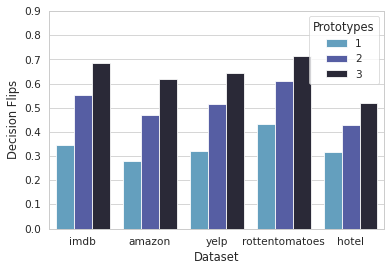

In [156]:
sns.barplot(x="Dataset", y="Decision Flips", hue="Prototypes", data=df, palette=sns.color_palette("icefire"))
plt.ylim(0,0.9)